#AAI-520 Final Project
##Students: Dan Arday, Kevin Akman
##Oct 21st, 2024

Imports

In [55]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.amp import autocast, GradScaler
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import kagglehub  # Import for downloading datasets
import pandas as pd
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Download latest version
path = kagglehub.dataset_download("rajathmc/cornell-moviedialog-corpus")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1


#EDA

In [28]:
# List all files in the dataset folder
files = os.listdir(path)
print("Files in dataset:", files)

# Adjust the filename based on actual content
dialogues_file = os.path.join(path, "movie_lines.txt")

# Load the dialogues with the correct delimiter '+++$$$+++'
dialogues = pd.read_csv(
    dialogues_file,
    sep=" \+\+\+\$\+\+\+ ",  # Regex pattern to handle the delimiter
    header=None,
    names=["line_id", "character_id", "movie_id", "character_name", "text"],
    engine='python',  # Required for regex separator
    encoding='latin1',
    on_bad_lines='skip'
)

# Preview the first few rows
dialogues.head()

Files in dataset: ['raw_script_urls.txt', 'chameleons.pdf', 'movie_characters_metadata.txt', 'movie_conversations.txt', 'movie_titles_metadata.txt', 'movie_lines.txt', '.DS_Store', 'README.txt']


,line_id,character_id,movie_id,character_name,text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [36]:
print(dialogues.sample(5))

        line_id character_id movie_id character_name  \
193682  L257137        u5668     m375         MARTIN   
22683   L141193         u715      m45           LILY   
215258  L356489        u6378     m425            BOB   
237705  L440952        u7052     m471        WHEELER   
110645  L595423        u3266     m216         THELMA   

                                                     text  
193682                                        How's that?  
22683                                                Why?  
215258                  What about you? Why are you here?  
237705  ... interview every employee, support staff, a...  
110645                   God.  You're a real live outlaw!  


In [37]:
# Check for missing values in the dataset
print(dialogues.isnull().sum())

line_id             0
character_id        0
movie_id            0
character_name     43
text              267
dtype: int64


In [38]:
# Summary statistics (for numerical columns, if any)
print(dialogues.describe())

# Data types of each column
print(dialogues.dtypes)

       line_id character_id movie_id character_name    text
count   304713       304713   304713         304670  304446
unique  304713         9035      617           5413  265808
top      L1045        u4525     m289           JACK   What?
freq         1          537     1530           3032    1684
line_id           object
character_id      object
movie_id          object
character_name    object
text              object
dtype: object


In [46]:
# Drop rows where 'text' is NaN
dialogues = dialogues.dropna(subset=['text'])

# Verify that the missing values are removed
print(dialogues.isnull().sum())

line_id            0
character_id       0
movie_id           0
character_name    43
text               0
dtype: int64


<Axes: >

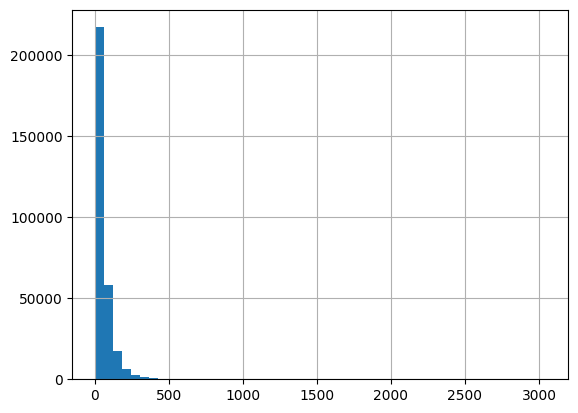

In [49]:
# Add a column for dialogue lengths
dialogues['text_length'] = dialogues['text'].apply(len)

# Plot distribution of dialogue lengths
dialogues['text_length'].hist(bins=50)

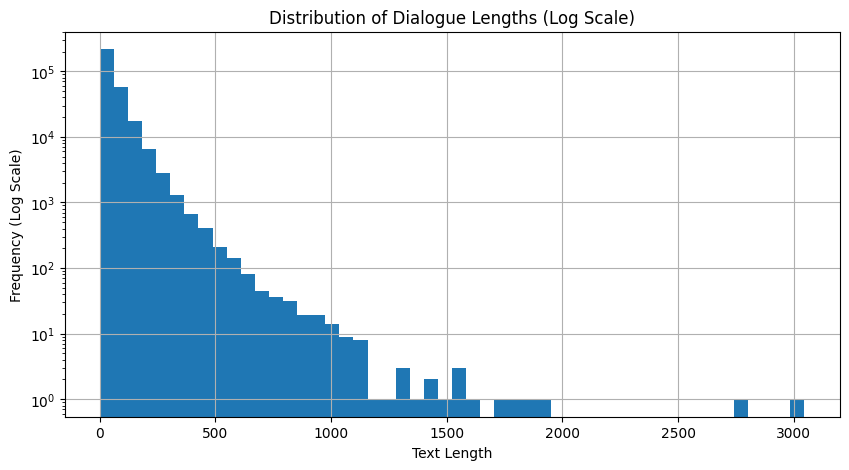

In [53]:
# Plot with log scale
plt.figure(figsize=(10, 5))
dialogues['text_length'].hist(bins=50)
plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.xlabel('Text Length')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Dialogue Lengths (Log Scale)')
plt.show()

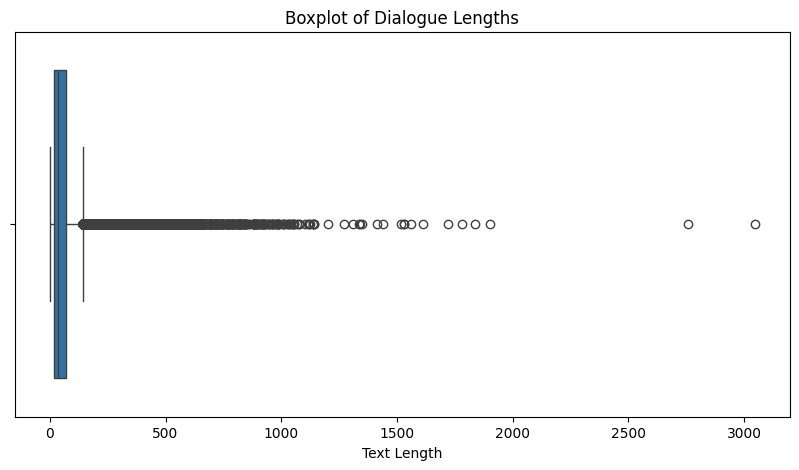

In [56]:
# Boxplot of dialogue lengths
plt.figure(figsize=(10, 5))
sns.boxplot(x=dialogues['text_length'])
plt.xlabel('Text Length')
plt.title('Boxplot of Dialogue Lengths')
plt.show()

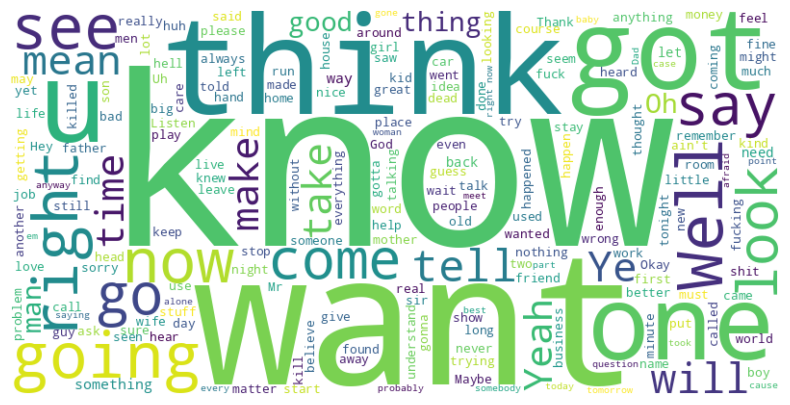

In [52]:
# Combine all text data into one string
all_text = " ".join(dialogues['text'].tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# GPT-2

In [18]:
# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Ensure that the tokenizer knows about padding tokens (GPT-2 doesn’t have it by default)
tokenizer.pad_token = tokenizer.eos_token  # Set pad token as the end-of-sentence token

# Example tokenization function
def tokenize_batch(dialogue_pairs):
    return tokenizer(dialogue_pairs, return_tensors='pt', padding=True, truncation=True)

# Example dialogues (replace with actual data)
dialogues = [
    "Hey, how are you?",
    "I'm good, thanks for asking!"
]

# Tokenize dialogues
tokenized_data = tokenize_batch(dialogues)

# Inspect the tokenized data
print(tokenized_data)


{'input_ids': tensor([[10814,    11,   703,   389,   345,    30, 50256, 50256],
        [   40,  1101,   922,    11,  5176,   329,  4737,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])}


In [19]:
# Optimizer and other configurations
optimizer = Adam(model.parameters(), lr=5e-5)
scaler = GradScaler()

# Hyperparameters
num_epochs = 3  # Define how many epochs you want to train for
accumulation_steps = 4  # Adjust based on VRAM capacity

# Dummy data (replace with actual DataLoader)
dataloader = DataLoader([...], batch_size=8)  # Replace with actual tokenized dataset

# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()

        # Autocast for mixed precision
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(**batch)
            loss = outputs.loss / accumulation_steps  # Normalize loss for gradient accumulation
            scaler.scale(loss).backward()

        # Gradient accumulation logic
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()  # Clear gradients after update


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'ellipsis'>

# Tests

# Conclusion